### Import modules

In [1]:
# Standard imports
import pandas as pd
import sys 
import os
import numpy as np
import matplotlib
from matplotlib.patches import Arc
import seaborn as sns
from matplotlib.cm import ScalarMappable
import os
import shutil
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit

def apply_better_style(right_ax = False, left_ax = True):
    # Apply better style
    sns.set_theme(style="whitegrid")
    custom_params = {"axes.spines.right": right_ax,"axes.spines.left": left_ax, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    #sns.set(font='Adobe Devanagari')
    sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3, 'axes.linewidth': 0.3})

    matplotlib.rcParams['mathtext.fontset'] = 'cm'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    # Not italized latex
    matplotlib.rcParams['mathtext.default'] = 'regular'
    matplotlib.rcParams["font.weight"] = "light"

    # retina plot
    matplotlib.rcParams['figure.dpi'] = 150
    matplotlib.rcParams['savefig.dpi'] = 150


In [2]:
# Get output data
df_sim_1 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000/output_particles.parquet")
df_sim_2 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000_repr/output_particles.parquet")

l_df_sim =[df_sim_1,df_sim_2]+[pd.read_parquet(f"/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000_repr_{i}/output_particles.parquet") for i in range(2,5)]

# Rename column x to x_init and y to y_init
l_df_sim = [df_sim.rename(columns={"x": "x_final", "y": "y_final"}) for df_sim in l_df_sim]

# Get input data
df_particle_1 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000/particles/00.parquet")
df_particle_2 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000_repr/particles/00.parquet")

l_df_particle = [df_particle_1,df_particle_2]+[pd.read_parquet(f"/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000_repr_{i}/particles/00.parquet") for i in range(2,5)]

# Merge dataframe and only keep the columns we need
l_df_sim = [pd.merge(df_sim, df_particle, on=["particle_id"]) for df_sim, df_particle in zip(l_df_sim, l_df_particle)]
l_df_sim = [df_sim[['at_turn', 'state', "x", "y"]] for df_sim in l_df_sim]

# Concatenate both df
df_sim = pd.concat(l_df_sim, ignore_index = True)
# add a column amplitude
df_sim.loc[:,"amplitude"] = np.sqrt(df_sim["x"]**2 + df_sim["y"]**2)


df_sim_survived = df_sim[df_sim['state'] == 1]
df_sim_lost = df_sim[df_sim['state'] != 1]

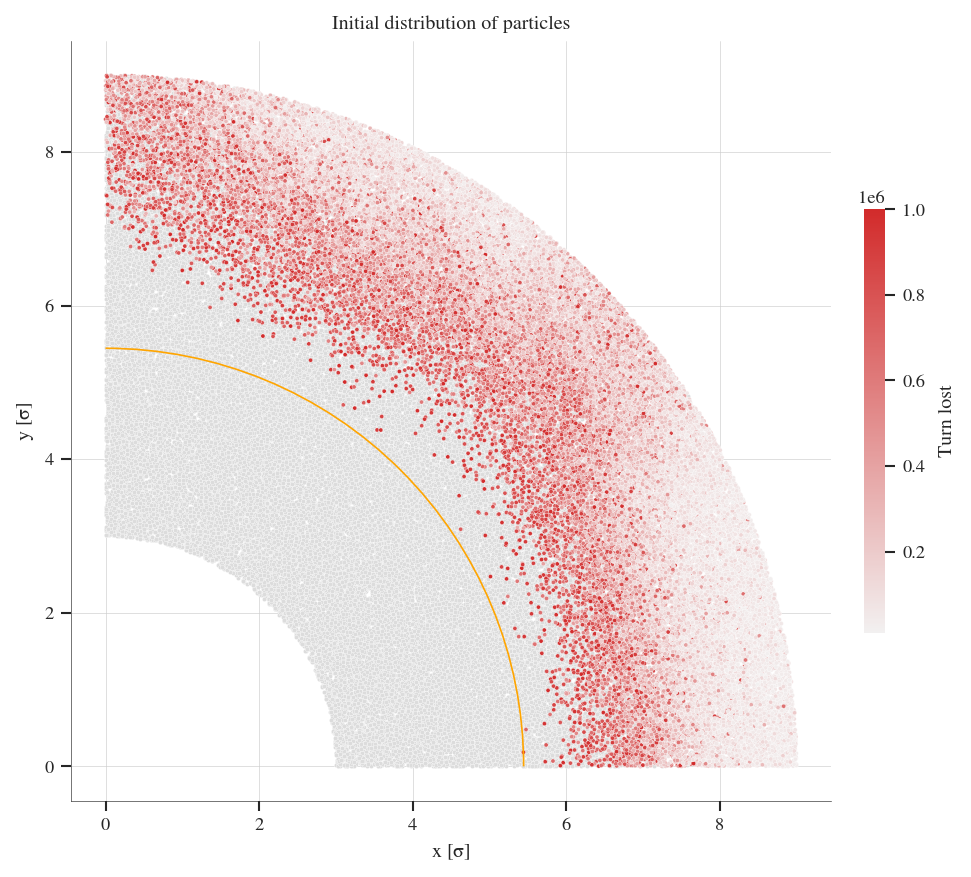

In [3]:
apply_better_style()
# Plot initial distribution of particles
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
norm = plt.Normalize(df_sim["at_turn"].min(), df_sim["at_turn"].max())
sm = sns.light_palette("#D22B2B", as_cmap=True, n_colors=100)
cmappable = ScalarMappable(norm=norm, cmap=sm)

sns.scatterplot(data=df_sim_survived, x="x", y="y", color = 'gainsboro', ax=ax, s=4)
sns.scatterplot(data=df_sim_lost, x="x", y="y", hue=df_sim_lost["at_turn"], palette = sm, ax=ax, s=4)
ax.set_xlabel(r"x [$\sigma$]")
ax.set_ylabel(r"y [$\sigma$]")
ax.set_title("Initial distribution of particles")
ax.get_legend().remove()
cbar = ax.figure.colorbar(cmappable, ax=ax, fraction=0.026, pad=0.04)
cbar.ax.set_ylabel("Turn lost", rotation=90, va="bottom", labelpad=15)
cbar.outline.set_visible(False)

# Add DA to plot
DA = np.min(df_sim_lost["amplitude"])
arc = Arc((0, 0), 2*DA, 2*DA, color='orange', theta1=0, theta2=90)
ax.add_patch(arc)
ax.set_aspect('equal', adjustable='box')

plt.grid(visible=None)
plt.show()

In [4]:

### Get minimum amplitude of particles lost as n_turn increases
df_sim_lost = df_sim_lost.sort_values(by="at_turn")

# Sample fully the first turns (otherwise percentiles are not accurate)
# for idx, at_turn in df_sim_lost['at_turn'][:1000].items():
#     df_sim_lost_so_far = df_sim_lost[df_sim_lost['at_turn'] <= at_turn]
#     df_sim_lost.loc[idx, 'min_amplitude'] = df_sim_lost_so_far['amplitude'].min()
#     df_sim_lost.loc[idx, 'median'] = df_sim_lost_so_far['amplitude'].median()
#     df_sim_lost.loc[idx, 'percentile_98'] = df_sim_lost_so_far['amplitude'].quantile(0.02)
#     df_sim_lost.loc[idx, 'percentile_90'] = df_sim_lost_so_far['amplitude'].quantile(0.1)
    
# Then do a sparser sampling
for idx, at_turn in df_sim_lost['at_turn'][::10].items():
    df_sim_lost_so_far = df_sim_lost[df_sim_lost['at_turn'] <= at_turn]
    df_sim_lost.loc[idx, 'min_amplitude'] = df_sim_lost_so_far['amplitude'].min()
    df_sim_lost.loc[idx, 'median'] = df_sim_lost_so_far['amplitude'].median()
    df_sim_lost.loc[idx, 'percentile_98'] = df_sim_lost_so_far['amplitude'].quantile(0.02)
    df_sim_lost.loc[idx, 'percentile_90'] = df_sim_lost_so_far['amplitude'].quantile(0.1)
    df_sim_lost.loc[idx, 'percentile_99'] = df_sim_lost_so_far['amplitude'].quantile(0.01)
    
### Compute the percentage of particles lost
tot_part = len(df_sim)
df_sim_lost['percent_lost'] = df_sim_lost['at_turn'].apply(lambda x: len(df_sim_lost[df_sim_lost['at_turn'] <= x])/tot_part*100)


In [5]:
df_sim_lost[::10]

,at_turn,state,x,y,amplitude,min_amplitude,median,percentile_98,percentile_90,percentile_99,percent_lost
20095,10950,-1,8.440222,2.256208,8.736580,8.736580,8.736580,8.736580,8.736580,8.736580,0.001
59107,16104,-1,8.087125,2.637239,8.506270,8.506270,8.754058,8.516013,8.554985,8.511141,0.011
21186,17291,-1,8.844710,1.433731,8.960161,8.357984,8.736580,8.409594,8.506270,8.383789,0.021
10382,17876,-1,8.957589,0.536437,8.973637,8.288710,8.752768,8.330275,8.478621,8.309493,0.031
52729,18592,-1,8.371194,1.528743,8.509638,8.288710,8.757589,8.320774,8.478621,8.304742,0.041
...,...,...,...,...,...,...,...,...,...,...,...
68523,995506,-1,3.732931,4.881110,6.144918,5.444343,8.115004,6.481017,7.035178,6.314853,38.581
11658,996439,-1,4.502204,5.381668,7.016565,5.444343,8.114652,6.480822,7.035113,6.314869,38.591
42064,997906,-1,4.531348,5.587357,7.193864,5.444343,8.114488,6.480772,7.035068,6.314726,38.601
26506,998814,-1,5.942359,2.026921,6.278538,5.444343,8.114212,6.479842,7.034352,6.313651,38.611


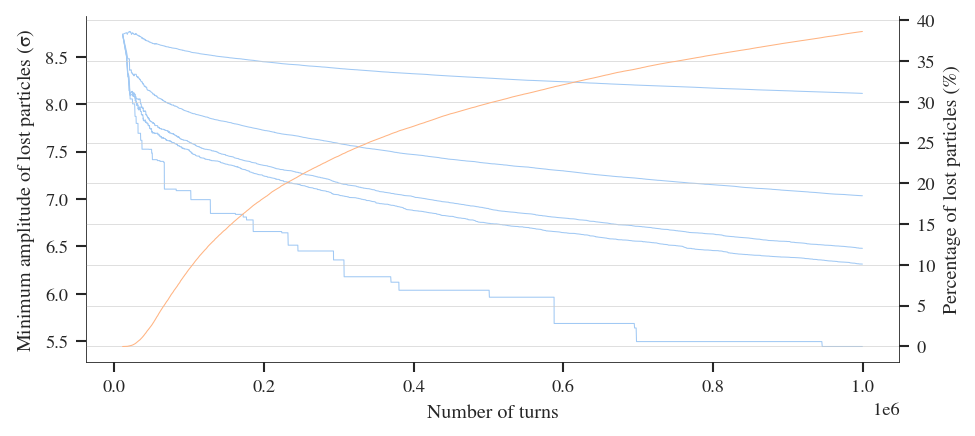

In [6]:
apply_better_style(right_ax = True)

# Plot evolution of minimum amplitude of particles lost and number of particles lost vs number of turns
# Do the plot with each lineplot having its own y-axis
l_colors = sns.color_palette("pastel")

fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
sns.lineplot(data=df_sim_lost[::10], x="at_turn", y="min_amplitude", ax=ax1, color=l_colors[0])
sns.lineplot(data=df_sim_lost[::10], x="at_turn", y="median", ax=ax1, color=l_colors[0])
sns.lineplot(data=df_sim_lost[::10], x="at_turn", y='percentile_98', ax=ax1, color=l_colors[0])
sns.lineplot(data=df_sim_lost[::10], x="at_turn", y='percentile_99', ax=ax1, color=l_colors[0])
sns.lineplot(data=df_sim_lost[::10], x="at_turn", y='percentile_90', ax=ax1, color=l_colors[0])
sns.lineplot(data=df_sim_lost[::10], x="at_turn", y="percent_lost", ax=ax2, color=l_colors[1])

ax1.set_xlabel("Number of turns")
ax1.set_ylabel(r"Minimum amplitude of lost particles ($\sigma$)")
ax2.set_ylabel("Percentage of lost particles (%)")
#ax1.set_title("Minimum amplitude of lost particles and percentage of lost particles vs number of turns")
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
plt.grid()
plt.show()





Now doing frame 0
Now doing frame 0
Now doing frame 100000
Now doing frame 200000
Now doing frame 300000
Now doing frame 400000
Now doing frame 500000
Now doing frame 600000
Now doing frame 700000
Now doing frame 800000
Now doing frame 900000
Now doing frame 0


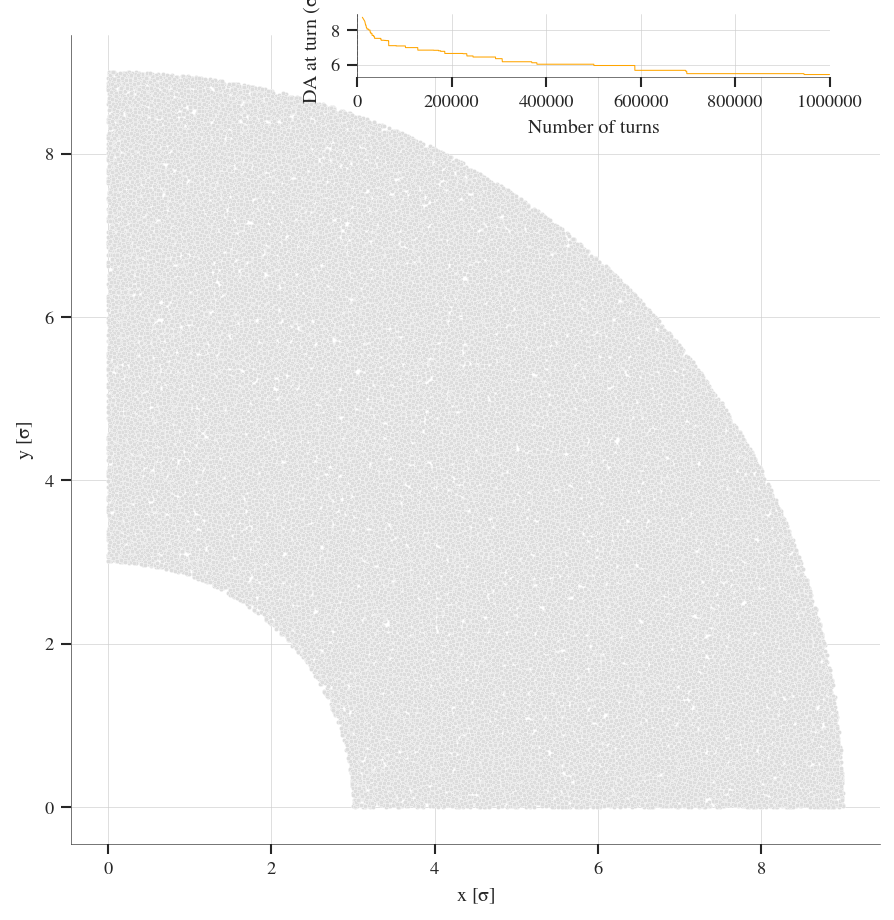

In [7]:
apply_better_style()

# Make an animation representing the DA as the number of turns increases
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
norm = plt.Normalize(df_sim["at_turn"].min(), df_sim["at_turn"].max())
sm = sns.light_palette("#D22B2B", as_cmap=True, n_colors=100)
cmappable = ScalarMappable(norm=norm, cmap=sm)


# Add inset plot for evolution of DA
ax_inset = fig.add_axes([0.4, 0.84, 0.45, 0.06])
sns.lineplot(data=df_sim_lost[:], x="at_turn", y="min_amplitude", ax=ax_inset, color='orange')
ax_inset.set_xlabel("Number of turns")
ax_inset.set_ylabel(r"DA at turn ($\sigma$)")
vline = ax_inset.axvline(x=0, color='darkgrey', linestyle='--')
ax_inset.set_xlim(0, df_sim["at_turn"].max())
ax_inset.grid(visible=True)
ax_inset.ticklabel_format(style='sci',scilimits=(-8,8),axis='both')

def update(frame):
    print('Now doing frame {}'.format(frame))
    ax.clear()
    sns.scatterplot(data=df_sim, x="x", y="y", color = 'gainsboro', ax=ax, s=4)
    df_lost_current_frame = df_sim_lost[df_sim_lost["at_turn"] <= frame]
    if len(df_lost_current_frame) > 0:
        sns.scatterplot(data=df_lost_current_frame, x="x", y="y", hue=df_lost_current_frame["at_turn"], palette = sm, ax=ax, s=4)
        ax.get_legend().remove()
        DA = df_lost_current_frame["min_amplitude"].min()
        arc = Arc((0, 0), 2*DA, 2*DA, color='orange', theta1=0, theta2=90)
        ax.add_patch(arc)
    
    ax.set_xlabel(r"x [$\sigma$]")
    ax.set_ylabel(r"y [$\sigma$]")
    # ax.set_title(f"Representation of particles lost at turn {frame}")
    
    # Update vertical line inset plot
    vline.set_xdata([frame,frame])
    ax_inset.grid(visible=True)

    ax.set_aspect('equal', adjustable='box')
    ax.grid(visible=True)
    
    # Color bar for latest turns
    # if frame >= 700000:
    #     cbar = ax.figure.colorbar(cmappable, ax=ax, fraction=0.026, pad=0.04)
    #     cbar.ax.set_ylabel("Turn lost", rotation=90, va="bottom", labelpad=15)
    #     cbar.outline.set_visible(False)

    return ax

ani = FuncAnimation(fig, update, frames=np.arange(0, 1000000, 100000), repeat=False)
ani.save('DA_evolution.gif', writer='imagemagick', fps=60)

In [8]:
n_repeat = 100
l_distr_DA = []
l_distr_percentile_95 = [] 
l_distr_median = []
l_distr_percentile_90 = []
# Get how the distribution of the DA evolves depending on the number of particles
l_subsampling_size = np.logspace(1, 16, 10, dtype=int, base = 2)
for subsampling_size in l_subsampling_size:
    l_DA_per_sample = []
    l_distr_percentile_95_per_sample = []
    l_distr_percentile_90_per_sample = []
    l_distr_median_per_sample = []
    for i in range(n_repeat):
        # Subsample df_sim_lost['amplitude']
        df_sampled = df_sim.sample(n=subsampling_size)
        # Only keep lost particles
        df_sampled = df_sampled[df_sampled['state'] != 1]
        # Compute distribution of DA
        l_DA_per_sample.append(np.min(df_sampled['amplitude']))
        percentile_95 = df_sampled['amplitude'].quantile(0.02)
        percentile_90 = df_sampled['amplitude'].quantile(0.1)
        # Compute percentile 95 and 90
        l_distr_percentile_95_per_sample.append(percentile_95)
        l_distr_percentile_90_per_sample.append(percentile_90)
        # Compute median
        l_distr_median_per_sample.append(df_sampled['amplitude'].quantile(0.5))
        
    l_distr_DA.append(l_DA_per_sample)
    l_distr_percentile_95.append(l_distr_percentile_95_per_sample)
    l_distr_percentile_90.append(l_distr_percentile_90_per_sample)
    l_distr_median.append(l_distr_median_per_sample)

In [9]:
# Create a df that contains the following columns: subsampling_size, DA, percentile_95, percentile_90, median
df_DA_distr = pd.DataFrame()
df_DA_distr['subsampling_size'] = np.repeat(l_subsampling_size, n_repeat)
df_DA_distr['DA'] = np.concatenate(l_distr_DA)
df_DA_distr['percentile_95'] = np.concatenate(l_distr_percentile_95)
df_DA_distr['percentile_90'] = np.concatenate(l_distr_percentile_90)
df_DA_distr['median'] = np.concatenate(l_distr_median)



In [10]:
df_DA_distr

,subsampling_size,DA,percentile_95,percentile_90,median
0,2,7.741817,7.747452,7.769994,7.882700
1,2,8.723332,8.723332,8.723332,8.723332
2,2,NaN,NaN,NaN,NaN
3,2,NaN,NaN,NaN,NaN
4,2,7.110211,7.110211,7.110211,7.110211
...,...,...,...,...,...
995,65536,5.560638,6.478900,7.043365,8.112437
996,65536,5.444343,6.470804,7.031101,8.105125
997,65536,5.606479,6.477647,7.032121,8.107309
998,65536,5.444343,6.475982,7.028620,8.107047


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

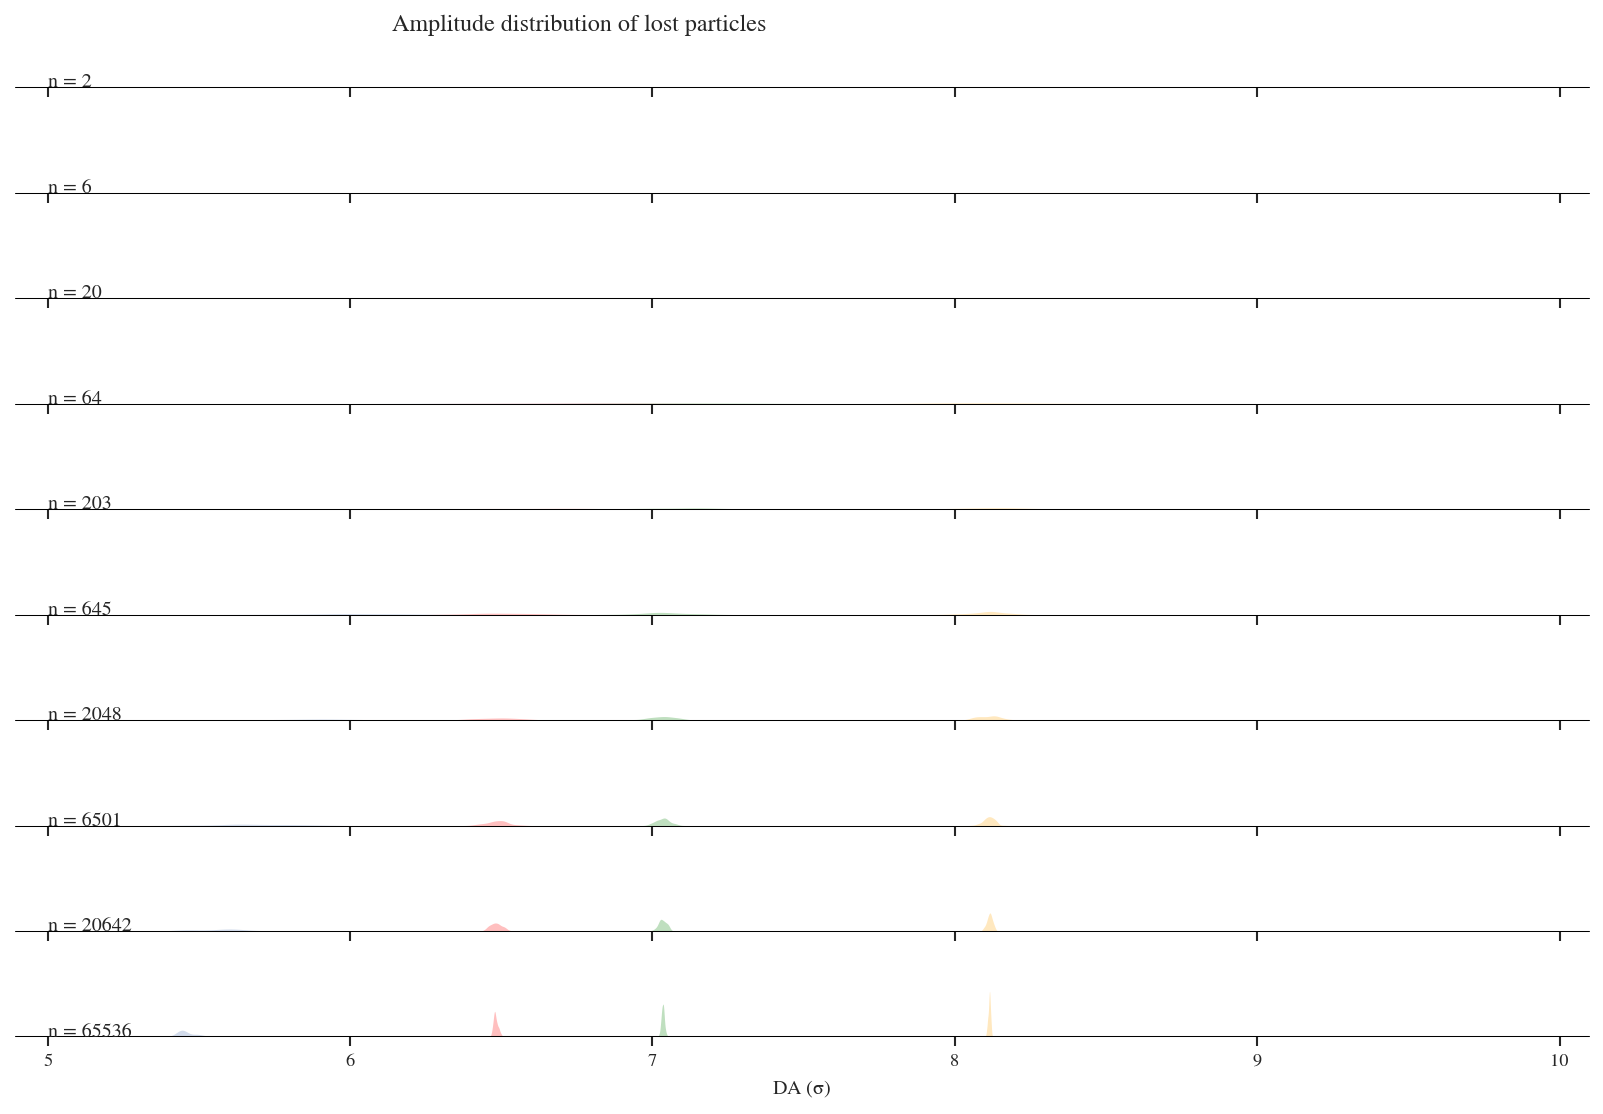

In [11]:
apply_better_style(right_ax = False, left_ax = False)


# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(df_DA_distr, row='subsampling_size', aspect=15, height=0.75)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'DA', bw_adjust=1, clip_on=False, fill=True, linewidth=0, common_norm = True)
g.map(sns.kdeplot, 'median', bw_adjust=1, clip_on=False, fill=True, linewidth=0, common_norm = True, color = 'orange')
g.map(sns.kdeplot, 'percentile_90', bw_adjust=1, clip_on=False, fill=True, linewidth=0, common_norm = True, color = 'green')
g.map(sns.kdeplot, 'percentile_95', bw_adjust=1, clip_on=False, fill=True, linewidth=0, common_norm = True, color = 'red')

# here we add a white line that represents the contour of each kdeplot
#g.map(sns.kdeplot, 'DA', bw_adjust=1, clip_on=False,  color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0, lw=0.5, clip_on=False, color = 'black')

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    ax.set(ylabel=None)
    ax.text(5, 0.5, "n = " + str(l_subsampling_size[i]))


# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
#g.fig.subplots_adjust(hspace=-0.3)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels())
plt.xlabel(r"DA ($\sigma$)")
g.fig.suptitle('Amplitude distribution of lost particles', ha='right')

plt.show()

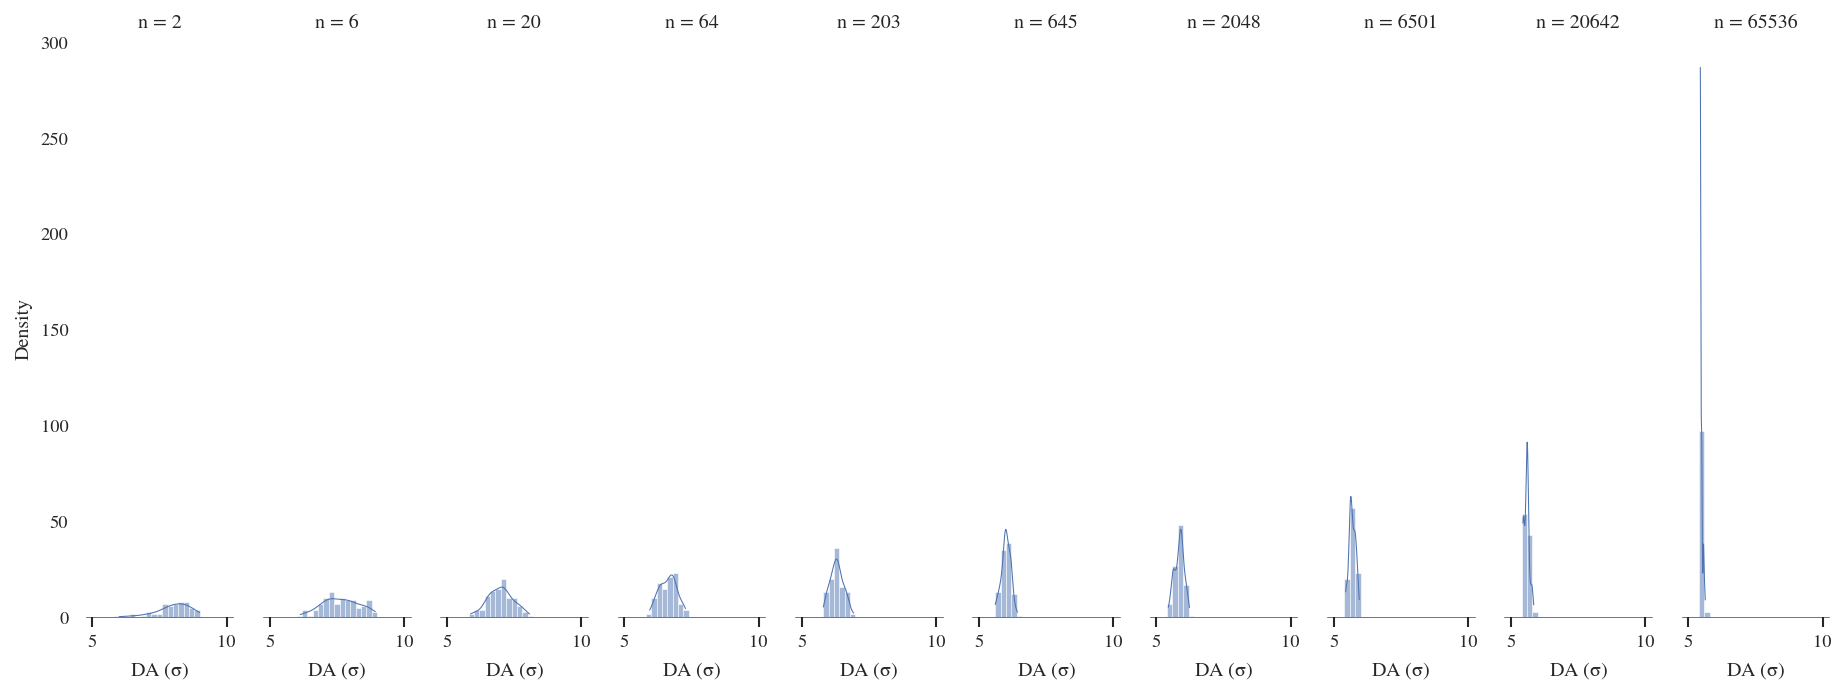

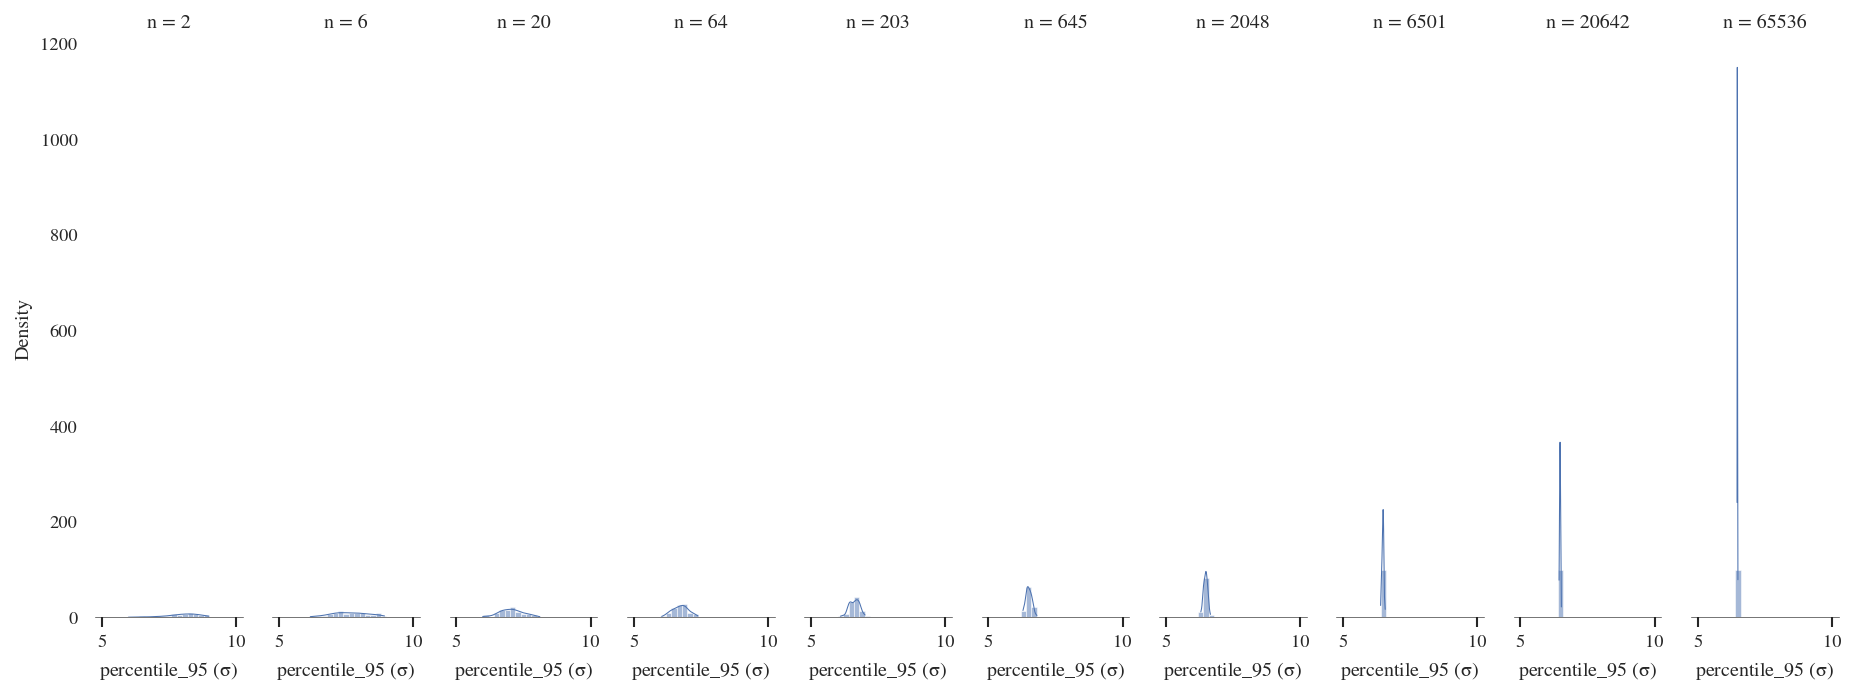

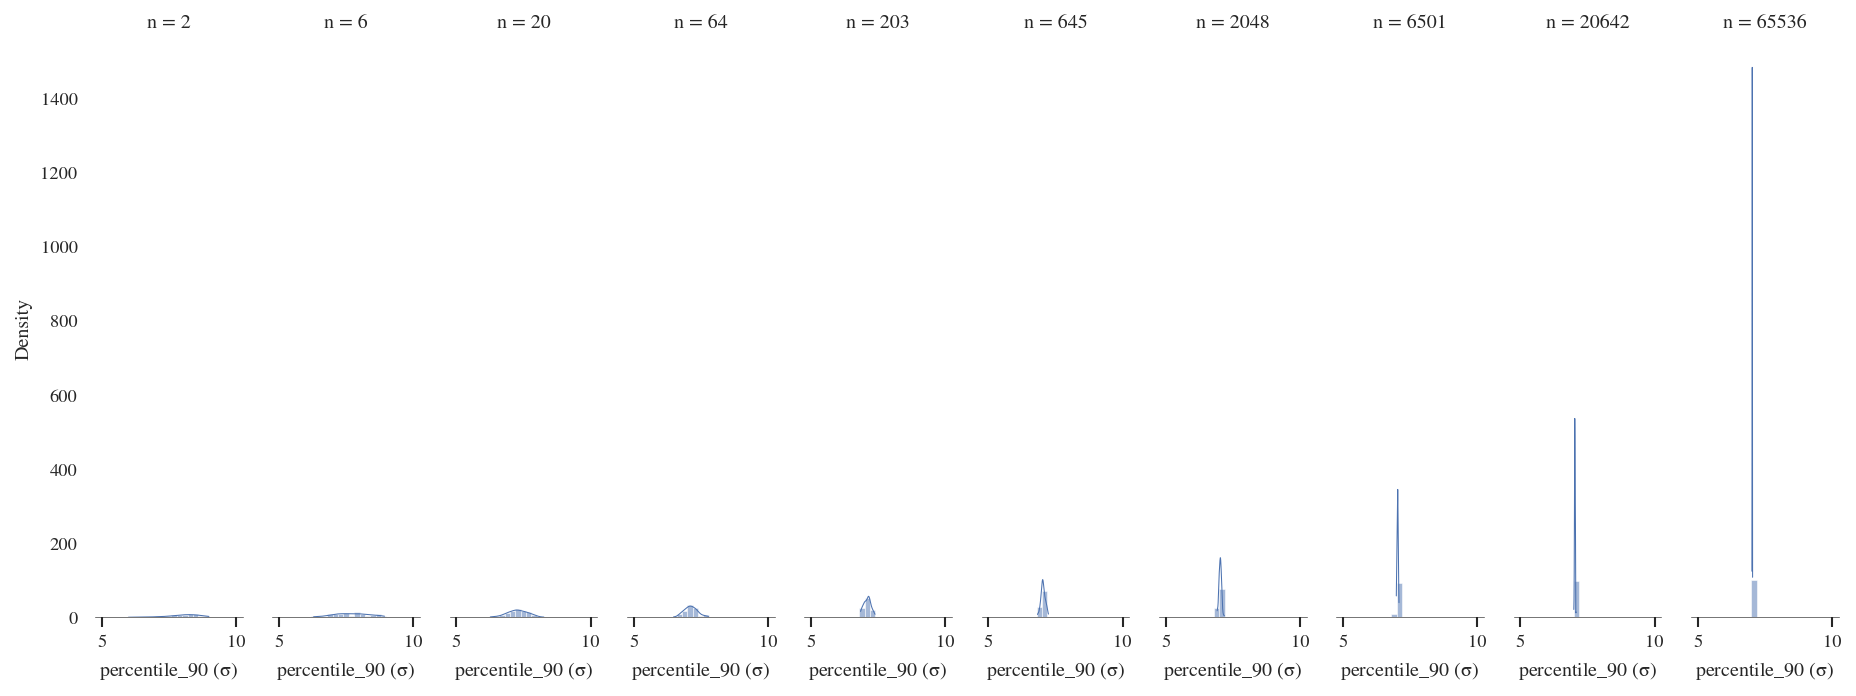

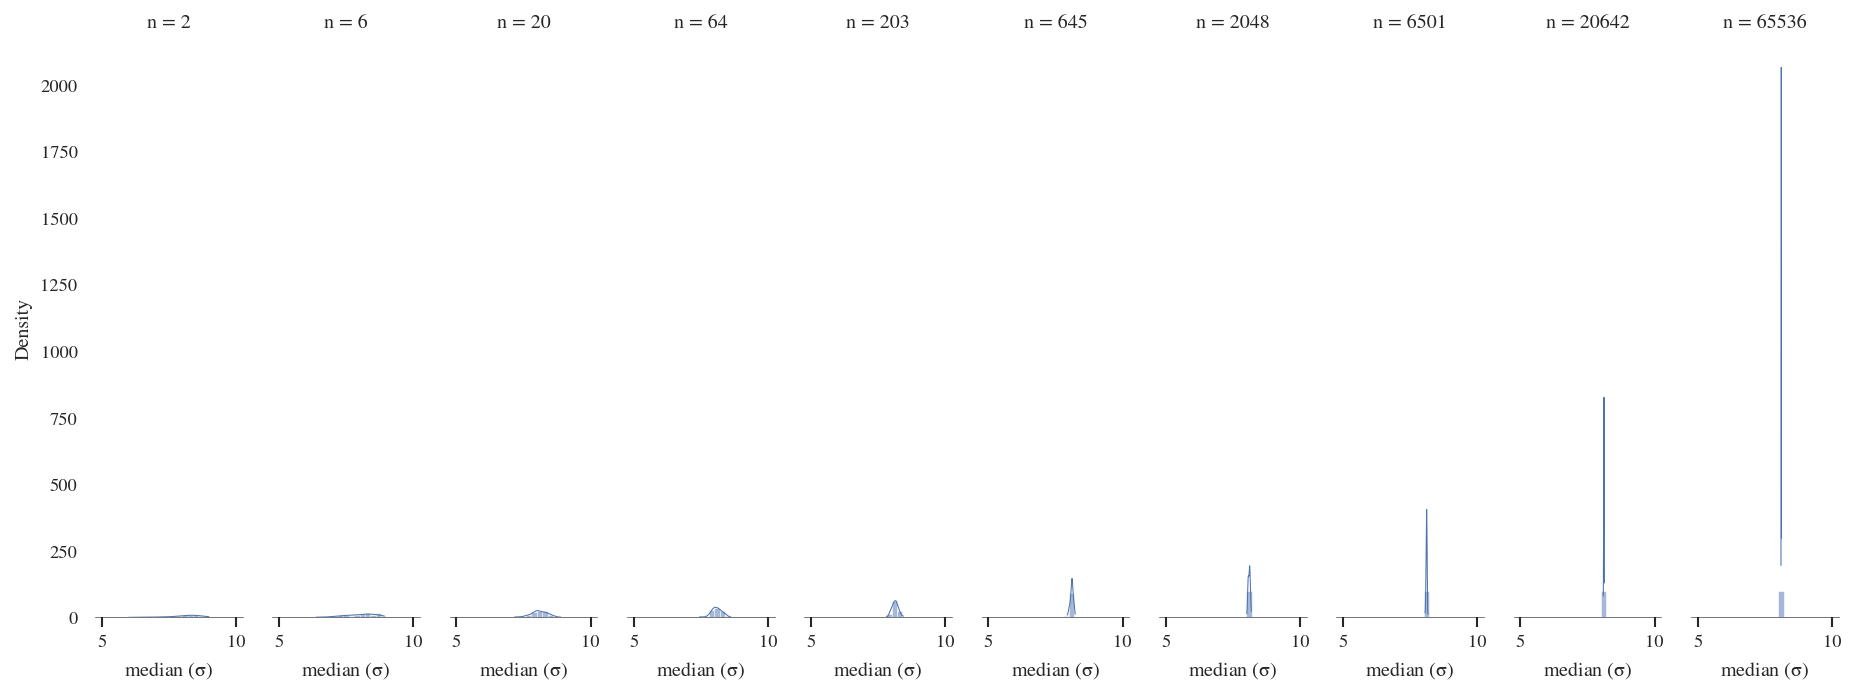

In [12]:
# Plot all the DA distributions, with normal fit, sharing the same y-axis
apply_better_style(right_ax = False, left_ax = False)
for l_variable, variable in zip([l_distr_DA, l_distr_percentile_95, l_distr_percentile_90, l_distr_median], ["DA", "percentile_95", "percentile_90", "median"]):
    fig, ax = plt.subplots(1, len(l_subsampling_size), figsize=(15, 5), sharey=True)
    for i, l_var_per_sample in enumerate(l_variable):
        sns.histplot(l_var_per_sample, kde=True, ax=ax[i], binrange=(5,10), binwidth = 0.2)
        ax[i].set_title(f"n = {l_subsampling_size[i]}")
        ax[i].set_xlabel(variable + r" ($\sigma$)")
        ax[i].set_ylabel("Density")
        ax[i].grid(visible=False)
        ax[i].tick_params(left=False, bottom=True)

    plt.show()    


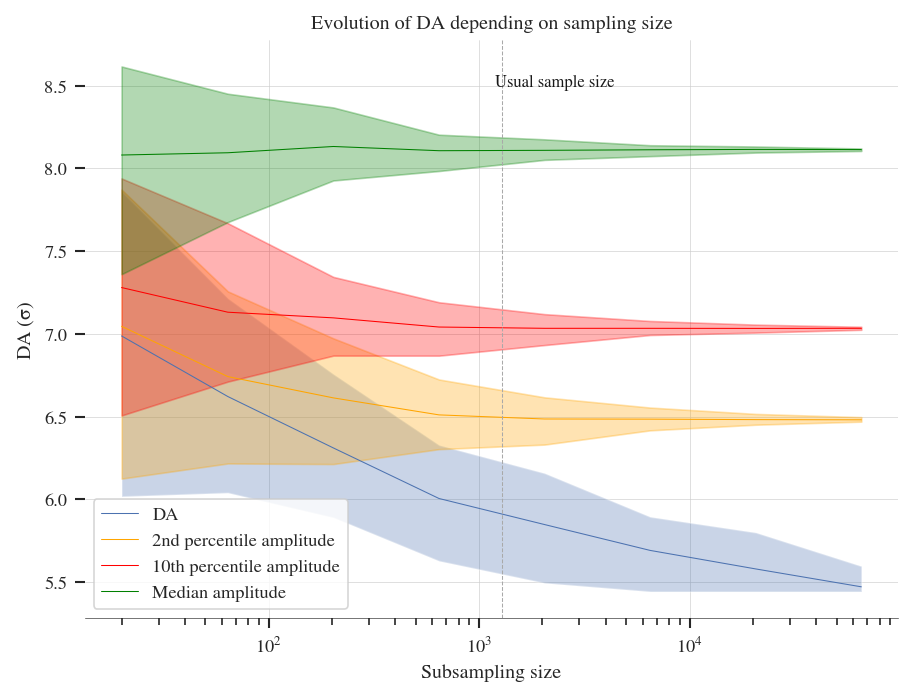

In [13]:
# Plot evolution of DA depending on sampling size, as line plot with confidence interval 
l_mean_DA = []
l_std_DA = []
l_conf_int_DA = []
for l_DA_per_sample in l_distr_DA:
    l_mean_DA.append(np.mean(l_DA_per_sample))
    l_std_DA.append(np.std(l_DA_per_sample))
    l_conf_int_DA.append(np.percentile(l_DA_per_sample, [2.5, 97.5]))

# Add percentile 95 to the plot
l_mean_percentile_95 = []
l_std_percentile_95 = []
l_conf_int_percentile_95 = []
for l_distr_percentile_95_per_sample in l_distr_percentile_95:
    l_mean_percentile_95.append(np.mean(l_distr_percentile_95_per_sample))
    l_std_percentile_95.append(np.std(l_distr_percentile_95_per_sample))
    l_conf_int_percentile_95.append(np.percentile(l_distr_percentile_95_per_sample, [2.5, 97.5]))

# Add percentile 90 to the plot
l_mean_percentile_90 = []
l_std_percentile_90 = []
l_conf_int_percentile_90 = []
for l_distr_percentile_90_per_sample in l_distr_percentile_90:
    l_mean_percentile_90.append(np.mean(l_distr_percentile_90_per_sample))
    l_std_percentile_90.append(np.std(l_distr_percentile_90_per_sample))
    l_conf_int_percentile_90.append(np.percentile(l_distr_percentile_90_per_sample, [2.5, 97.5]))

# Add median to the plot
l_mean_median = []
l_std_median = []
l_conf_int_median = []
for l_distr_median_per_sample in l_distr_median:
    l_mean_median.append(np.mean(l_distr_median_per_sample))
    l_std_median.append(np.std(l_distr_median_per_sample))
    l_conf_int_median.append(np.percentile(l_distr_median_per_sample, [2.5, 97.5]))


fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(x=l_subsampling_size, y=l_mean_DA, ax=ax, label='DA')
ax.fill_between(l_subsampling_size, np.array(l_conf_int_DA)[:,0], np.array(l_conf_int_DA)[:,1], alpha=0.3)

# add percentile 95
sns.lineplot(x=l_subsampling_size, y=l_mean_percentile_95, ax=ax, color='orange', label='2nd percentile amplitude')
ax.fill_between(l_subsampling_size, np.array(l_conf_int_percentile_95)[:,0], np.array(l_conf_int_percentile_95)[:,1], alpha=0.3, color='orange')

# Add percentile 90
sns.lineplot(x=l_subsampling_size, y=l_mean_percentile_90, ax=ax, color='red', label='10th percentile amplitude')
ax.fill_between(l_subsampling_size, np.array(l_conf_int_percentile_90)[:,0], np.array(l_conf_int_percentile_90)[:,1], alpha=0.3, color='red')

# Add median
sns.lineplot(x=l_subsampling_size, y=l_mean_median, ax=ax, color='green', label='Median amplitude')
ax.fill_between(l_subsampling_size, np.array(l_conf_int_median)[:,0], np.array(l_conf_int_median)[:,1], alpha=0.3, color='green')

# Add vertical line at 1280 particles with text stating: "Usual sample size"
ax.axvline(x=1280, color='darkgrey', linestyle='--', lw = 0.5)
ax.text(2300, 8.5, "Usual sample size", color='black', fontsize=8, ha='center', alpha=0.9)

ax.set_xscale('log')
ax.set_xlabel("Subsampling size")
ax.set_ylabel("DA ($\sigma$)")
ax.set_title("Evolution of DA depending on sampling size")
ax.grid(visible=True)
plt.show()



### Study influence of initial distribution on final DA

In [14]:
# Test diffent distributions, all with subsampling size 1280
ll_x = []
ll_y = []
angle_space = np.logspace(0,9,10, dtype=int, base = 2)
for n_angles in angle_space:
    l_angles = np.linspace(0,np.pi/2, n_angles + 2, endpoint = True)[1:-1]
    n_amplitudes = 1280//n_angles
    l_amplitudes = np.linspace(3,9, n_amplitudes)
    ll_x.append([np.cos(angle)*amplitude for angle in l_angles for amplitude in l_amplitudes])
    ll_y.append([np.sin(angle)*amplitude for angle in l_angles for amplitude in l_amplitudes])

# Look for indices of closest neighbors in the master distribution (df_sim)
l_indices = []
for l_x, l_y in zip(ll_x, ll_y):
    l_indices.append([np.argmin((df_sim['x'] - x)**2 + (df_sim['y'] - y)**2) for x, y in zip(l_x, l_y)])

In [15]:
angle_space

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

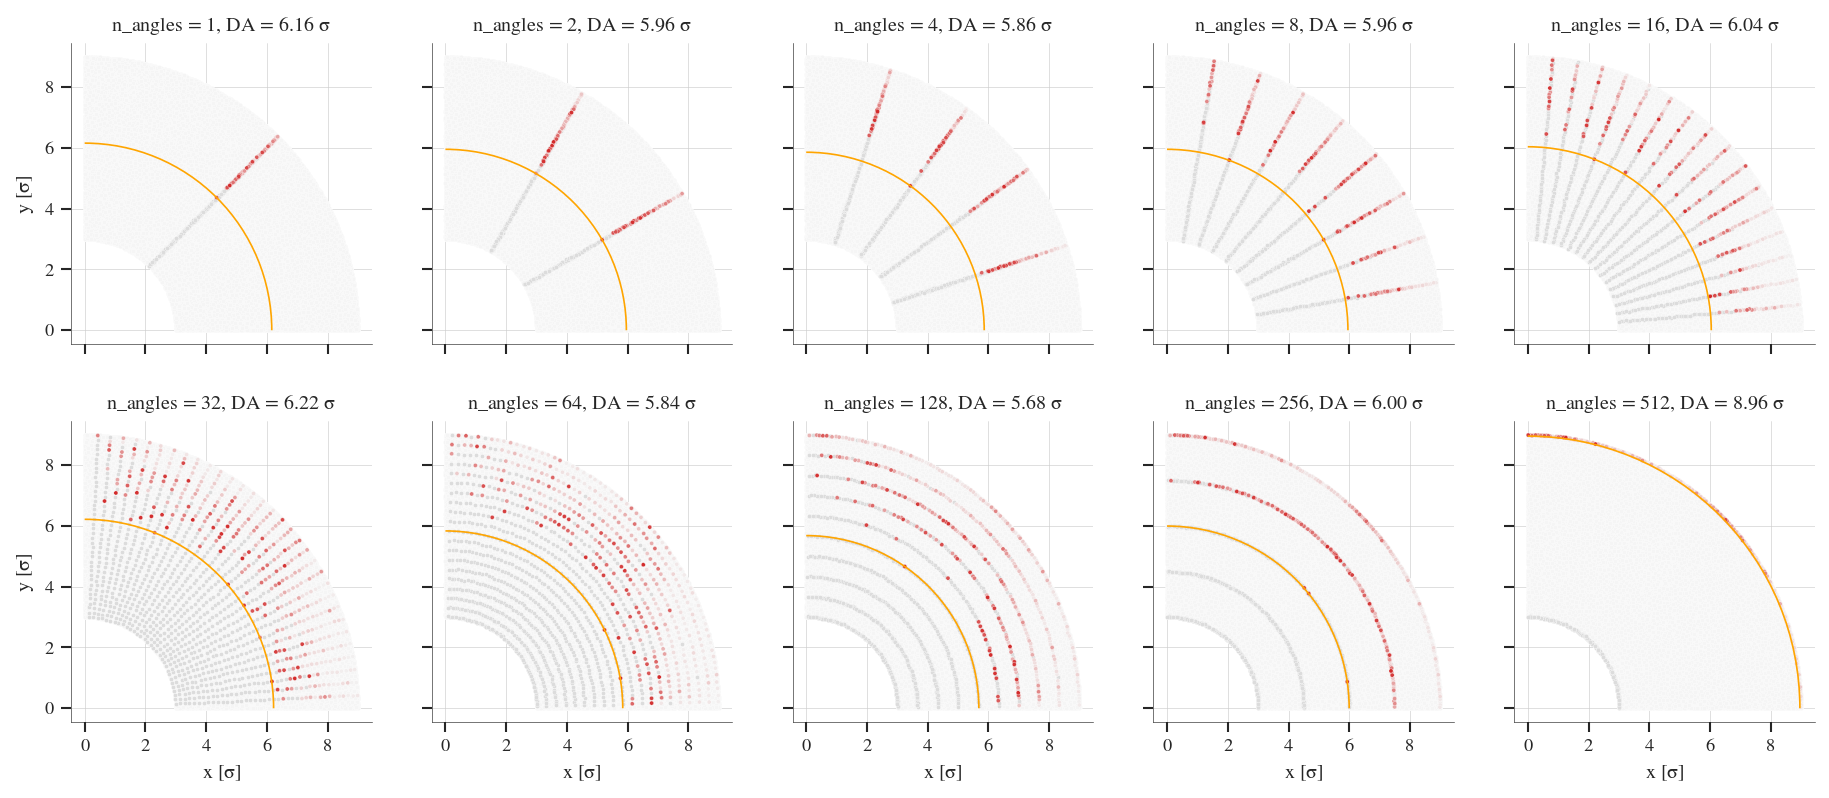

In [16]:

apply_better_style()
fig, ax = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
norm = plt.Normalize(df_sim["at_turn"].min(), df_sim["at_turn"].max())
sm = sns.light_palette("#D22B2B", as_cmap=True, n_colors=100)
cmappable = ScalarMappable(norm=norm, cmap=sm)
for i, indices in enumerate(l_indices):
    # Plot the master distribution with the closest neighbors highlighted
    sns.scatterplot(data=df_sim, x="x", y="y", color = 'whitesmoke', ax=ax[i//5, i%5], s=4)
    sns.scatterplot(data=df_sim_survived.loc[df_sim_survived.index.isin(indices)], x="x", y="y", color = 'gainsboro', ax=ax[i//5, i%5], s=4)
    sns.scatterplot(data=df_sim_lost.loc[df_sim_lost.index.isin(indices)], x="x", y="y", hue=df_sim_lost.loc[df_sim_lost.index.isin(indices)]["at_turn"], palette = sm, ax=ax[i//5, i%5], s=4)

    ax[i//5, i%5].get_legend().remove()
    ax[i//5, i%5].set_xlabel(r"x [$\sigma$]")
    ax[i//5, i%5].set_ylabel(r"y [$\sigma$]")
    
    #cbar = ax.figure.colorbar(cmappable, ax=ax, fraction=0.026, pad=0.04)
    #cbar.ax.set_ylabel("Turn lost", rotation=90, va="bottom", labelpad=15)
    #cbar.outline.set_visible(False)

    # Add DA to plot
    DA = np.min(df_sim_lost.loc[df_sim_lost.index.isin(indices)]["amplitude"])
    ax[i//5, i%5].set_title(f"n_angles = {angle_space[i]}, DA = {DA:.2f} $\sigma$")
    arc = Arc((0, 0), 2*DA, 2*DA, color='orange', theta1=0, theta2=90)
    ax[i//5, i%5].add_patch(arc)
    ax[i//5, i%5].set_aspect('equal', adjustable='box')

    ax[i//5, i%5].grid(visible=None)
plt.show()



In [17]:
# Plot evolution of DA depending on the topology of the distribution
ll_x = []
ll_y = []
angle_space = np.linspace(1,500,500,endpoint = True, dtype=int)
for n_angles in angle_space:
    l_angles = np.linspace(0,np.pi/2, n_angles + 2, endpoint = True)[1:-1]
    n_amplitudes = 1280//n_angles
    l_amplitudes = np.linspace(3,9, n_amplitudes)
    ll_x.append([np.cos(angle)*amplitude for angle in l_angles for amplitude in l_amplitudes])
    ll_y.append([np.sin(angle)*amplitude for angle in l_angles for amplitude in l_amplitudes])

# Look for indices of closest neighbors in the master distribution (df_sim)
l_indices = []
for l_x, l_y in zip(ll_x, ll_y):
    l_indices.append([np.argmin((df_sim['x'] - x)**2 + (df_sim['y'] - y)**2) for x, y in zip(l_x, l_y)])

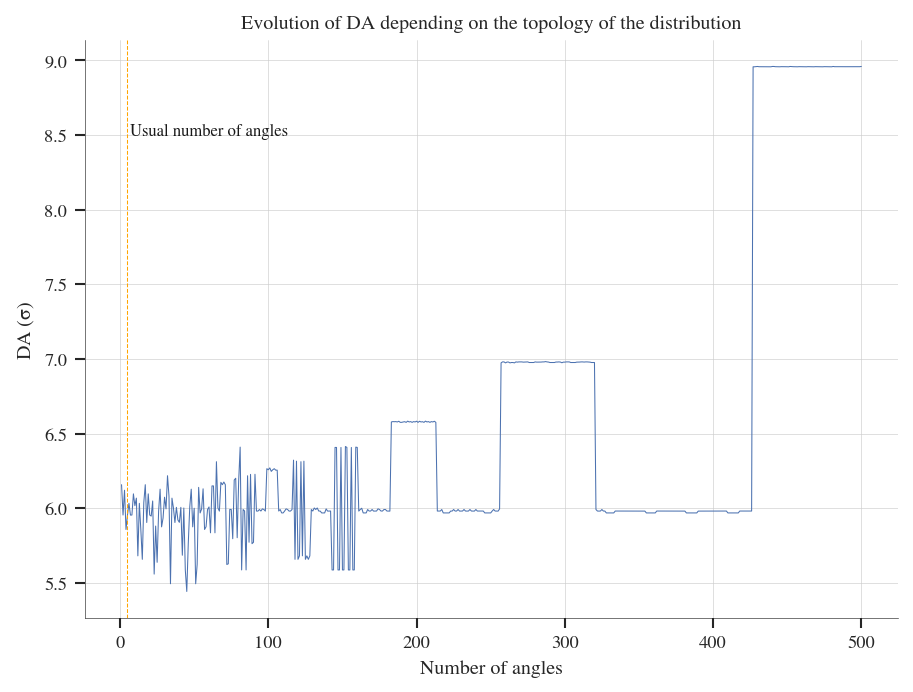

In [18]:
l_DA = [np.min(df_sim_lost.loc[df_sim_lost.index.isin(indices)]["amplitude"]) for indices in l_indices]

# Plot evolution of DA depending on the topology of the distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(x=angle_space, y=l_DA, ax=ax)
ax.axvline(x=5, color='orange', linestyle='--', lw = 0.5)
ax.text(60, 8.5, "Usual number of angles", color='black', fontsize=8, ha='center', alpha=0.9)
ax.set_xlabel("Number of angles")
ax.set_ylabel("DA ($\sigma$)")
ax.set_title("Evolution of DA depending on the topology of the distribution")
ax.grid(visible=True)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.show()



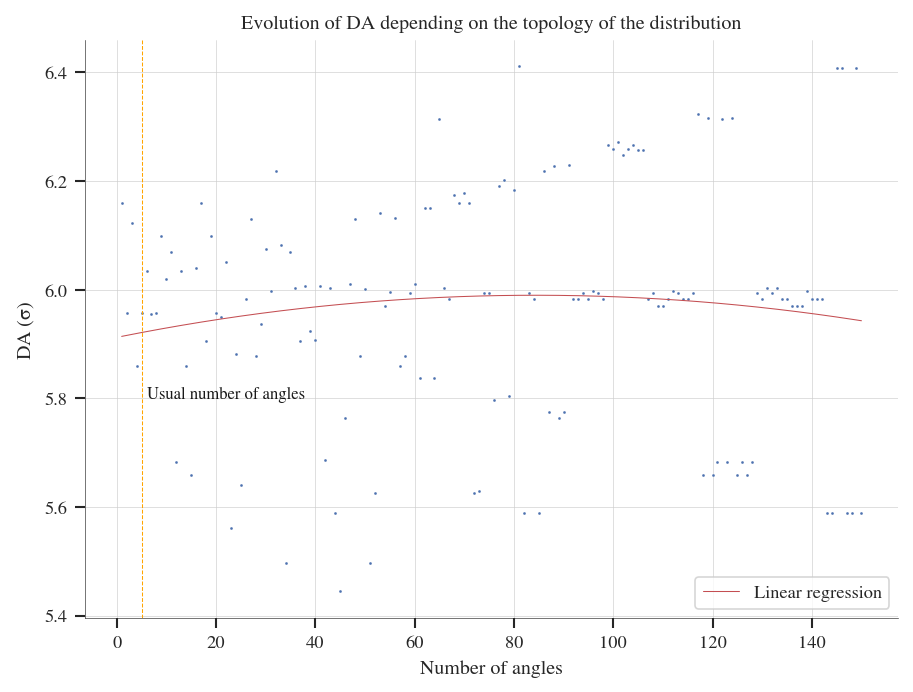

In [19]:
# Plot evolution of DA depending on the topology of the distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.scatterplot(x=angle_space[:150], y=l_DA[:150], s = 2, ax=ax)
# Make a linear regression of order 2
z = np.polyfit(angle_space[:150], l_DA[:150], 2)
p = np.poly1d(z)
ax.plot(angle_space[:150],p(angle_space[:150]),"r-", label = 'Linear regression')
ax.axvline(x=5, color='orange', linestyle='--', lw = 0.5)
ax.text(22, 5.8, "Usual number of angles", color='black', fontsize=8, ha='center', alpha=0.9)
ax.set_xlabel("Number of angles")
ax.set_ylabel("DA ($\sigma$)")
ax.set_title("Evolution of DA depending on the topology of the distribution")
ax.grid(visible=True)
plt.legend()
plt.show()

Compute confidence on the value of the DA through bootstrapping.

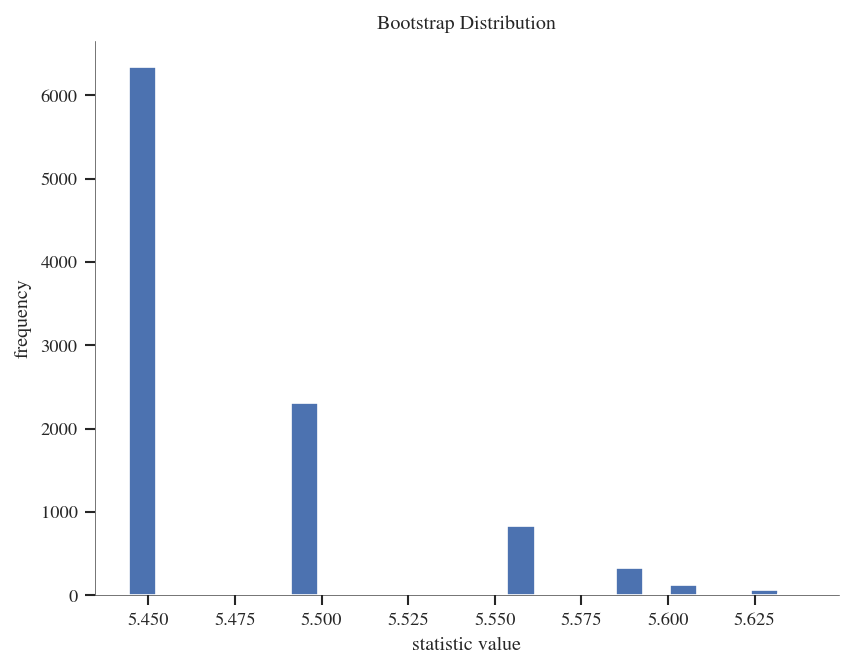

In [20]:
res = bootstrap((df_sim_lost['amplitude'].values,), np.min, confidence_level=0.9)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

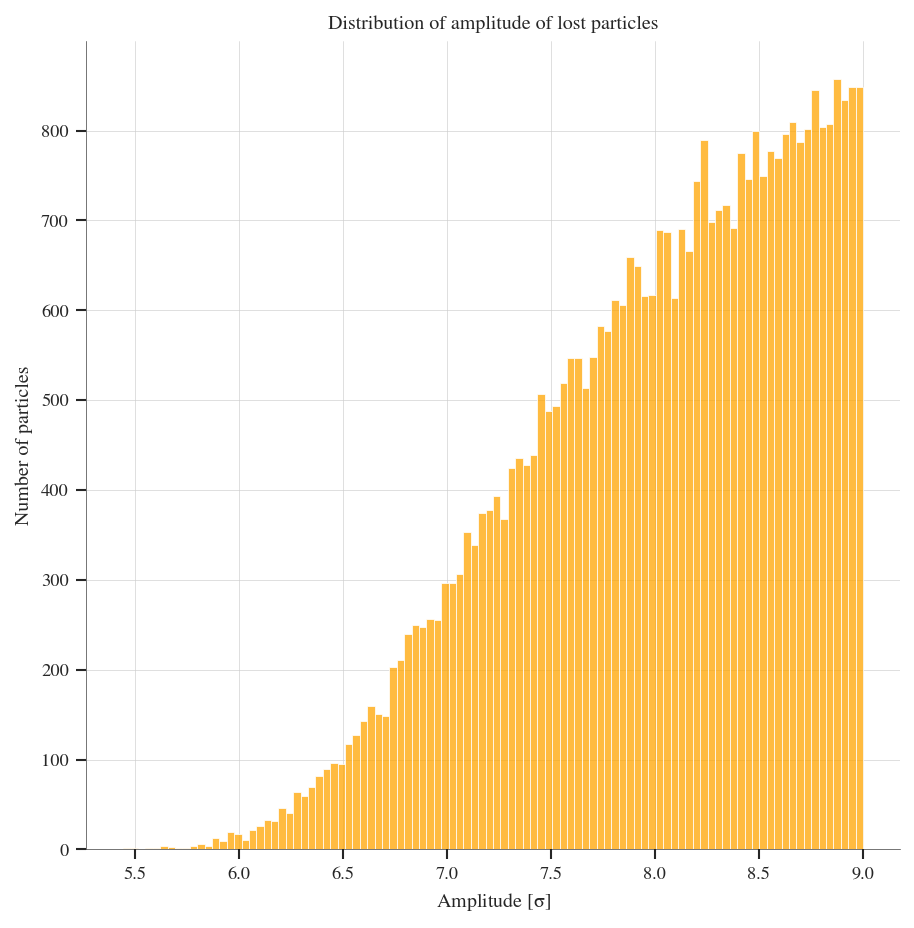

In [21]:
# Plot distribution of amplitude of lost particles
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.histplot(data=df_sim_lost, x="amplitude", bins=100, ax=ax, color='orange')
ax.set_xlabel(r"Amplitude [$\sigma$]")
ax.set_ylabel("Number of particles")
ax.set_title("Distribution of amplitude of lost particles")
plt.grid()


In [22]:
# Center and normalize the data
df_sim_lost['normalized_amplitude'] = (df_sim_lost['amplitude'].max()-df_sim_lost['amplitude'])

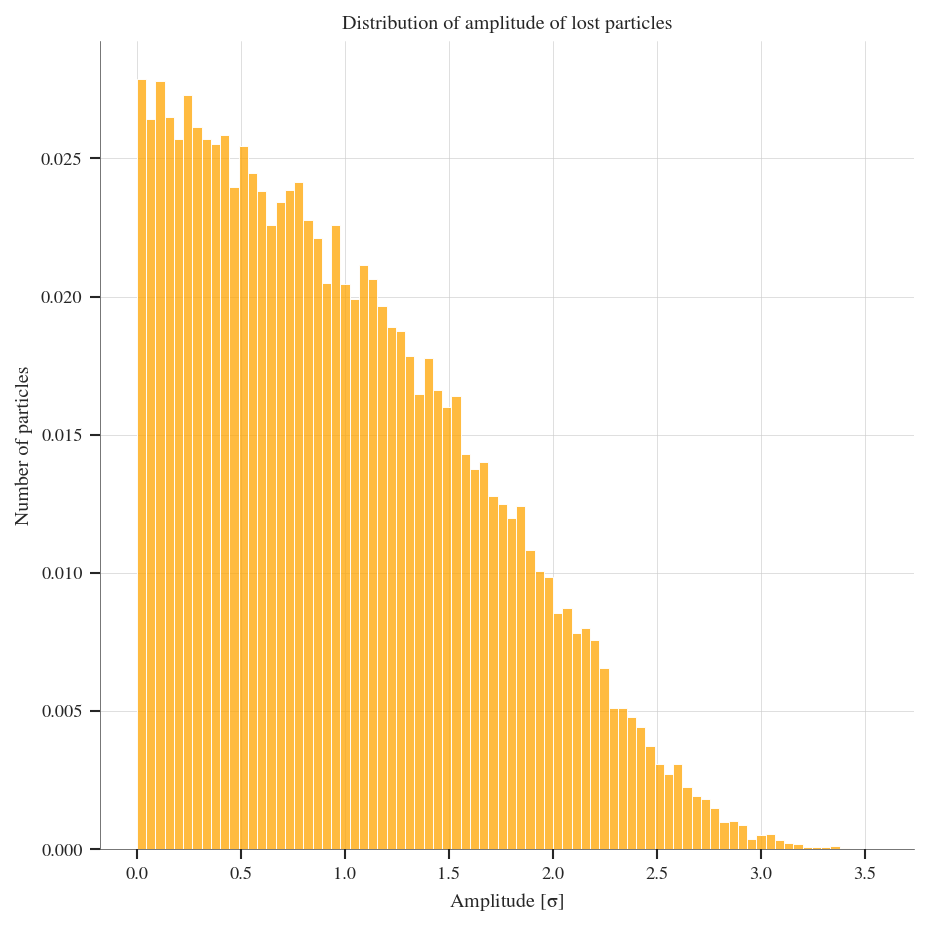

In [23]:
# Plot distribution of amplitude of lost particles
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.histplot(data=df_sim_lost, x="normalized_amplitude", bins=80, ax=ax, color='orange', stat = 'probability')
ax.set_xlabel(r"Amplitude [$\sigma$]")
ax.set_ylabel("Number of particles")
ax.set_title("Distribution of amplitude of lost particles")
plt.grid()

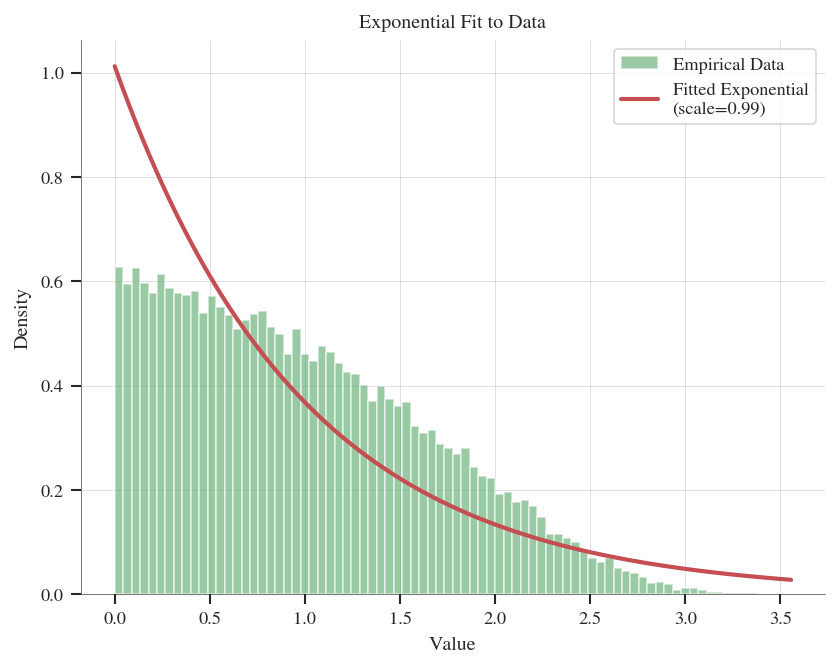

In [24]:
from scipy.stats import expon

# Get distribution amplitude
hist_amplitude, bin_edges_amplitude = np.histogram(df_sim_lost['normalized_amplitude'], bins=80, density=True)
bin_centers_amplitude = (bin_edges_amplitude[:-1] + bin_edges_amplitude[1:]) / 2
bin_width_amplitude = bin_edges_amplitude[1] - bin_edges_amplitude[0]

# Step 1: Calculate the MLE for λ
sample_mean = np.mean(df_sim_lost['normalized_amplitude'])
lambda_hat = 1 / sample_mean

# Step 2: Plot the empirical distribution
plt.hist(df_sim_lost['normalized_amplitude'], bins=80, density=True, alpha=0.6, color='g', label='Empirical Data')

# Plot the fitted exponential distribution
x = np.linspace(0, np.max(df_sim_lost['normalized_amplitude']), 1000)
pdf_fitted = expon.pdf(x, scale=1/lambda_hat)
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Exponential\n(scale={1/lambda_hat:.2f})')

plt.title('Exponential Fit to Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()



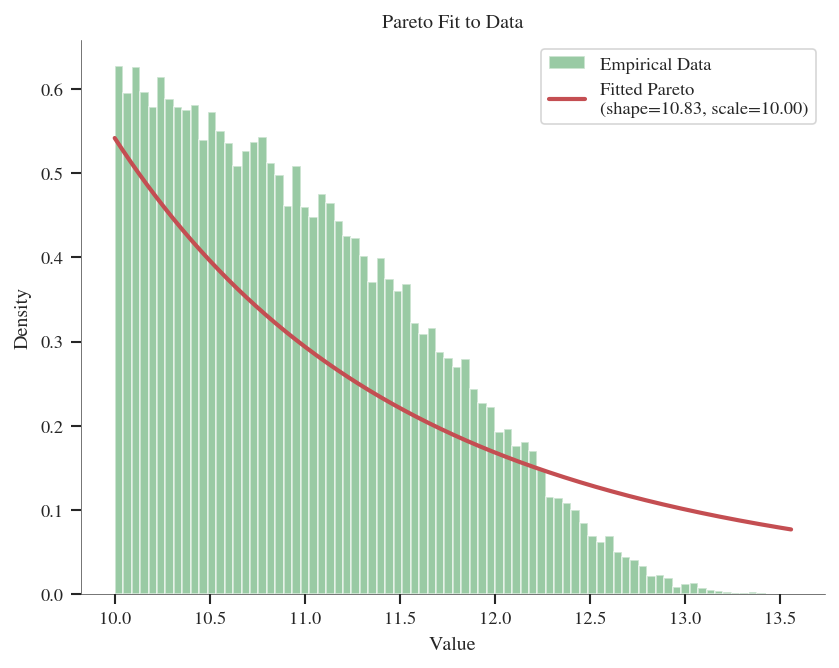

In [41]:
from scipy.stats import pareto

# Add one to the amplitude distribution for the fitting
df_sim_lost['normalized_amplitude'] = df_sim_lost['normalized_amplitude'] + 1

# Step 1: Calculate the MLE for α
x_m = np.min(df_sim_lost['normalized_amplitude'])
alpha_hat = len(df_sim_lost['normalized_amplitude']) / np.sum(np.log(df_sim_lost['normalized_amplitude'] / x_m))

# Step 2: Plot the empirical distribution
plt.hist(df_sim_lost['normalized_amplitude'], bins=80, density=True, alpha=0.6, color='g', label='Empirical Data')

# Plot the fitted Pareto distribution
x = np.linspace(x_m, np.max(df_sim_lost['normalized_amplitude']), 1000)
pdf_fitted = pareto.pdf(x, alpha_hat*0.5, scale=x_m)
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Pareto\n(shape={alpha_hat:.2f}, scale={x_m:.2f})')

plt.title('Pareto Fit to Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


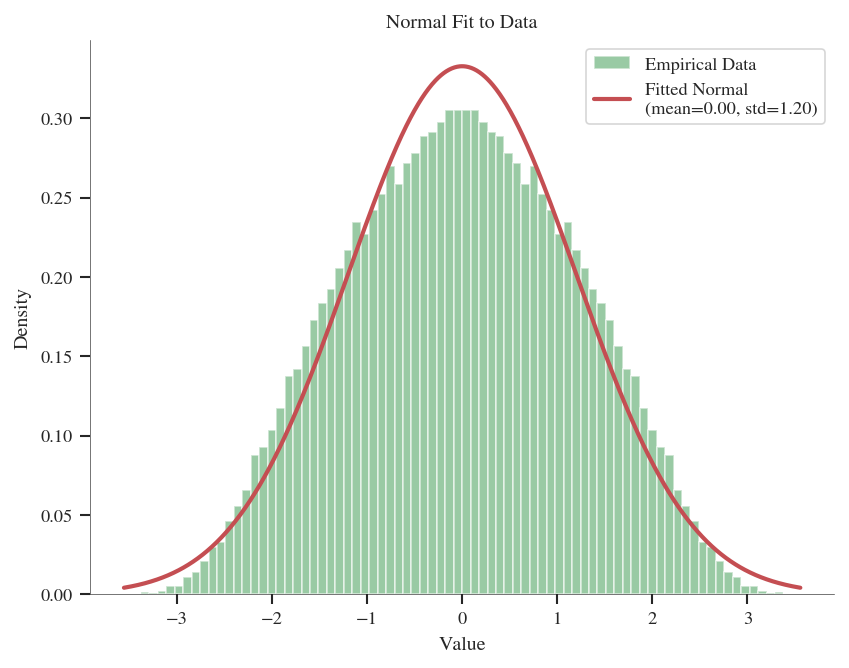

In [26]:
# Try now with a normal distribution
from scipy.stats import norm

# Make the distribution symmetric
df_sim_lost['amplitude_centered'] = df_sim_lost['amplitude'] - np.max(df_sim_lost['amplitude'])
array_amplitude_symmetric = np.hstack((df_sim_lost['amplitude_centered'].values, -df_sim_lost['amplitude_centered'].values))

# Step 1: Calculate the MLE for μ and σ
mu_hat = np.mean(array_amplitude_symmetric)
sigma_hat = np.std(array_amplitude_symmetric)

# Step 2: Plot the empirical distribution
plt.hist(array_amplitude_symmetric, bins=80, density=True, alpha=0.6, color='g', label='Empirical Data')

# Plot the fitted Normal distribution
x = np.linspace(np.min(array_amplitude_symmetric), np.max(array_amplitude_symmetric), 1000)
pdf_fitted = norm.pdf(x, mu_hat, sigma_hat)
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Normal\n(mean={mu_hat:.2f}, std={sigma_hat:.2f})')

plt.title('Normal Fit to Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

0.0 0.8861477936478148


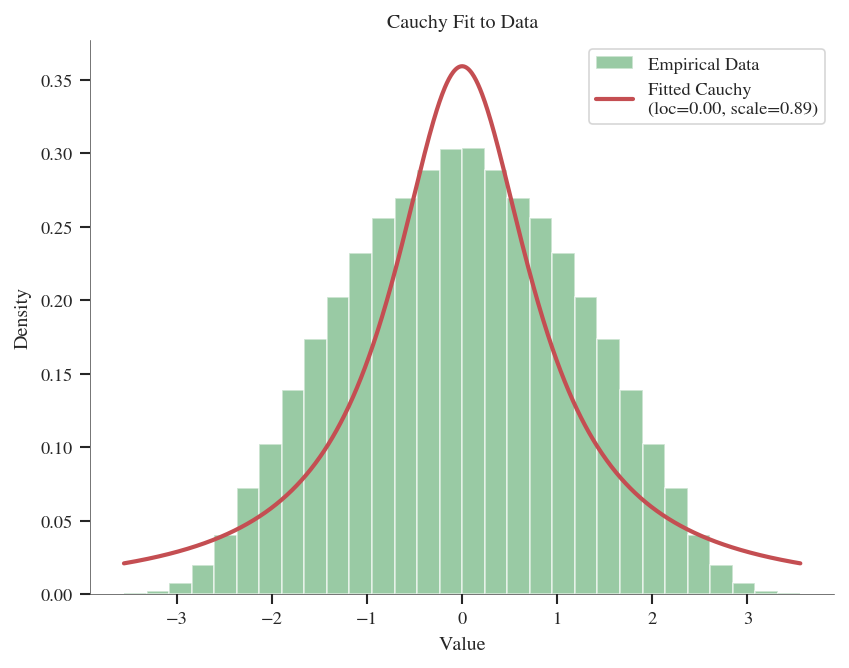

In [27]:
# Try the fit with cauchy distribution
from scipy.stats import cauchy

# Step 1: Calculate the estimates for x_0 and γ
x0_hat = np.median(array_amplitude_symmetric)
iqr = np.percentile(array_amplitude_symmetric, 75) - np.percentile(array_amplitude_symmetric, 25)
gamma_hat = iqr / 2

# Step 2: Plot the empirical distribution
plt.hist(array_amplitude_symmetric, bins=30, density=True, alpha=0.6, color='g', label='Empirical Data')

# Plot the fitted Cauchy distribution
x = np.linspace(np.min(array_amplitude_symmetric), np.max(array_amplitude_symmetric), 1000)
pdf_fitted = cauchy.pdf(x, loc=x0_hat, scale=gamma_hat)
print(x0_hat, gamma_hat)
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Cauchy\n(loc={x0_hat:.2f}, scale={gamma_hat:.2f})')

plt.title('Cauchy Fit to Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()



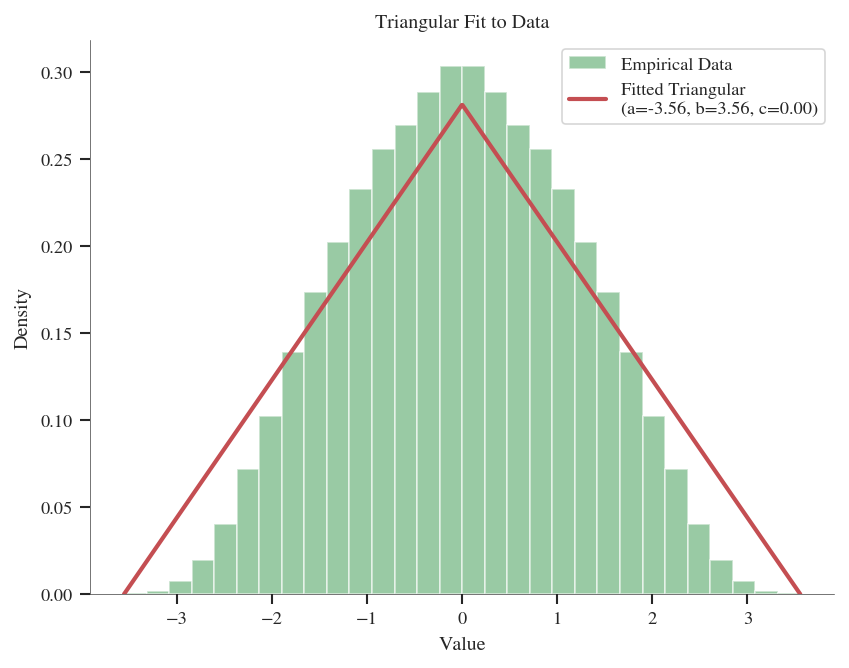

In [28]:
from scipy.stats import triang

# Step 1: Estimate the parameters
a_hat = np.min(array_amplitude_symmetric)
b_hat = np.max(array_amplitude_symmetric)
c_hat = np.median(array_amplitude_symmetric)  # Mode can be approximated using the sample median

# Step 2: Plot the empirical distribution
plt.hist(array_amplitude_symmetric, bins=30, density=True, alpha=0.6, color='g', label='Empirical Data')

# Plot the fitted Triangular distribution
c_relative = (c_hat - a_hat) / (b_hat - a_hat)  # Convert mode to relative location
x = np.linspace(a_hat, b_hat, 1000)
pdf_fitted = triang.pdf(x, c_relative, loc=a_hat, scale=b_hat - a_hat)
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Triangular\n(a={a_hat:.2f}, b={b_hat:.2f}, c={c_hat:.2f})')

plt.title('Triangular Fit to Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

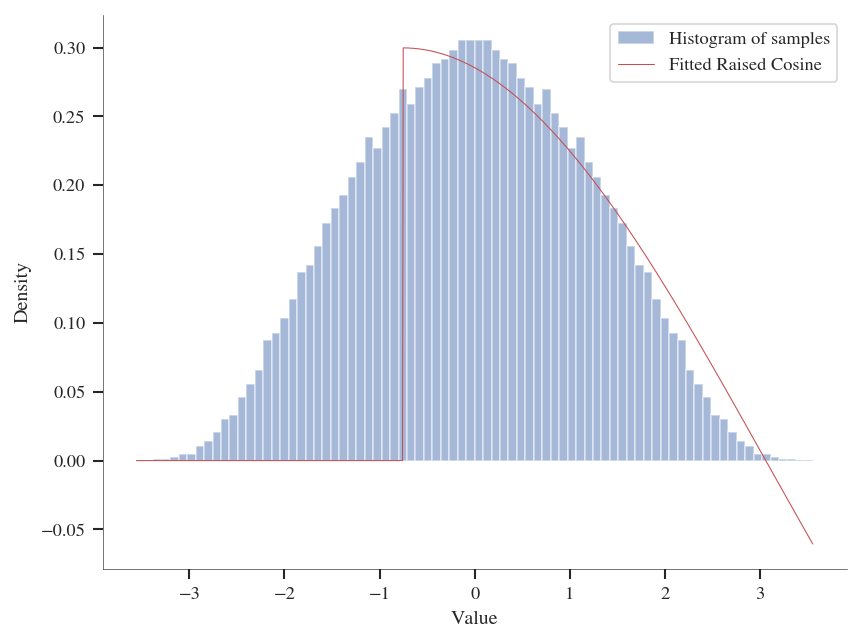

In [46]:
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the raised cosine distribution function
def raised_cosine(x, A, mu, sigma):
    return A * np.cos((x - mu) * np.pi / sigma) * (1 + np.sign(x - mu)) / 2 

# Generate random samples from a distribution (e.g., normal distribution)
# You can replace this with your desired distribution
# mu = 0
# sigma = 1
# samples = truncnorm.rvs(-2, 2, loc=mu, scale=sigma, size=1000)

# Compute the histogram of the samples
hist, bins = np.histogram(array_amplitude_symmetric, bins=80, density=True)

# Find the bin centers
bin_centers = (bins[1:] + bins[:-1]) / 2

# Fit the raised cosine distribution to the histogram
params, cov = curve_fit(raised_cosine, bin_centers, hist, p0=[1, 0, 3])

# Plot the histogram of the samples and the fitted raised cosine distribution
plt.hist(array_amplitude_symmetric, bins=80, density=True, alpha=0.5, label='Histogram of samples')
x = np.linspace(min(array_amplitude_symmetric), max(array_amplitude_symmetric), 1000)
plt.plot(x, raised_cosine(x, *params), 'r-', label='Fitted Raised Cosine')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()